<a href="https://colab.research.google.com/github/yutianma1802/master-thesis/blob/peptide-inhibition-assay/hASMT_inhibition_activity_assay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell: Load raw_ic50.xlsx into `df`
from pathlib import Path
import os
import pandas as pd
import numpy as np

# try the expected filename first, otherwise pick the first .xlsx in the folder
p = Path('inhibition test raw data.xlsx') # Corrected filename
if not p.exists():
    xls = list(Path('.').glob('*.xlsx'))
    if len(xls) == 0:
        raise FileNotFoundError(f"inhibition test raw data.xlsx not found and no .xlsx files present in {Path('.').resolve()}") # Corrected filename
    # choose first candidate but warn
    p = xls[0]
    print(f"Warning: 'inhibition test raw data.xlsx' not found; using '{p.name}' instead.") # Corrected filename

# read with openpyxl engine (recommended for .xlsx)
try:
    df = pd.read_excel(p, engine='openpyxl')
except Exception as e:
    raise RuntimeError(f"Failed to read Excel file {p}: {e}")

# normalize column names: strip whitespace and convert to string
df.columns = [str(c).strip() for c in df.columns]

print(f"Loaded '{p.name}' -> df with shape {df.shape}")
print('First 30 columns:')
print(df.columns.tolist()[:30])

# quick peek
try:
    display(df.head())
except Exception:
    print(df.head().to_string())

# note: if your time column or well names are different from expected, run `print(df.columns.tolist())` to inspect

Loaded 'inhibition test raw data.xlsx' -> df with shape (60, 97)
First 30 columns:
['Time [s]', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5']


,Time [s],A1,A2,A3,A4,A5,A6,A7,A8,A9,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0.000,0.5211,0.5210,0.5179,0.5503,0.5630,0.5761,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60.012,0.5209,0.5209,0.5175,0.5505,0.5628,0.5748,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,120.039,0.5199,0.5208,0.5169,0.5501,0.5615,0.5742,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,180.057,0.5189,0.5198,0.5159,0.5497,0.5612,0.5735,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240.068,0.5174,0.5182,0.5152,0.5497,0.5613,0.5730,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Build `signal_ts` (with - without) per concentration index and estimate propagated SEMs
import re
import numpy as np
import pandas as pd

# ensure df is present
if 'df' not in globals():
    try:
        df = pd.read_excel('inhibition test raw data.xlsx', engine='openpyxl') # Corrected filename
        df.columns = [str(c).strip() for c in df.columns]
        print("Loaded df inside signal builder")
    except Exception as e:
        raise RuntimeError("`df` not found and failed to read inhibition test raw data.xlsx: " + str(e)) # Corrected filename

# detect well-like columns (e.g., A1, B3)
well_cols = [c for c in df.columns if re.match(r"^[A-Za-z]+\d+$", str(c).strip())]
if not well_cols:
    raise RuntimeError('No well-like columns found (expected names like A1, B3, ...).')

# parse row letter and column number
parsed = {str(c).strip(): re.match(r"^([A-Za-z]+)(\d+)$", str(c).strip()).groups() for c in well_cols}
letters = sorted({v[0].upper() for v in parsed.values()})

# Define wells with and without enzyme based on user input
with_enzyme_wells_map = {
    '0': ['A1', 'A2', 'A3'],
    '1': ['B1', 'B2', 'B3'],
    '10': ['C1', 'C2', 'C3'],
    '100': ['D1', 'D2', 'D3'],
    '10000': ['E1', 'E2', 'E3'],
    '100000': ['F1', 'F2', 'F3']
}

without_enzyme_wells_map = {
    '0': ['A4', 'A5', 'A6'],
    '1': ['B4', 'B5', 'B6'],
    '10': ['C4', 'C5', 'C6'],
    '100': ['D4', 'D5', 'D6'],
    '10000': ['E4', 'E5', 'E6'],
    '100000': ['F4', 'F5', 'F6']
}

# Ensure all specified wells exist in the dataframe
all_specified_wells = [well for wells in with_enzyme_wells_map.values() for well in wells] + \
                      [well for wells in without_enzyme_wells_map.values() for well in wells]
missing_wells = [well for well in all_specified_wells if well not in df.columns]
if missing_wells:
    raise RuntimeError(f"The following specified wells were not found in the dataframe: {missing_wells}")


signal_ts = {}
signal_sem_ts = {}
peptide_concs = sorted([float(c) for c in with_enzyme_wells_map.keys()])

for conc in peptide_concs:
    conc_str = str(int(conc)) if conc.is_integer() else str(conc)
    with_cols = with_enzyme_wells_map.get(conc_str, [])
    without_cols = without_enzyme_wells_map.get(conc_str, [])

    if with_cols and without_cols:
        wdf = df[with_cols].apply(pd.to_numeric, errors='coerce')
        bdf = df[without_cols].apply(pd.to_numeric, errors='coerce')
        mean_with = wdf.mean(axis=1).values
        mean_without = bdf.mean(axis=1).values
        signal = mean_with - mean_without
        # estimate SEM per timepoint for each group then propagate
        sem_with = wdf.std(axis=1, ddof=1) / np.sqrt(max(1, len(with_cols)))
        sem_without = bdf.std(axis=1, ddof=1) / np.sqrt(max(1, len(without_cols)))
        sem = np.sqrt(np.nan_to_num(sem_with)**2 + np.nan_to_num(sem_without)**2)
        signal_ts[conc] = signal
        signal_sem_ts[conc] = sem
    else:
        # couldn't form groups; fill with NaNs
        signal_ts[conc] = np.full(len(df), np.nan)
        signal_sem_ts[conc] = np.full(len(df), np.nan)


pair_concs = np.array(peptide_concs)

print('Constructed signal_ts for peptide concentrations:', peptide_concs)
print('pair_concs:', pair_concs)
# provide a lightweight check
for k in list(signal_ts.keys()):
    print(f"conc {k}: signal length={len(signal_ts[k])}, sem length={len(signal_sem_ts[k])}")

# make available at module globals
globals()['signal_ts'] = signal_ts
globals()['signal_sem_ts'] = signal_sem_ts
globals()['pair_concs'] = pair_concs

Constructed signal_ts for peptide concentrations: [0.0, 1.0, 10.0, 100.0, 10000.0, 100000.0]
pair_concs: [0.e+00 1.e+00 1.e+01 1.e+02 1.e+04 1.e+05]
conc 0.0: signal length=60, sem length=60
conc 1.0: signal length=60, sem length=60
conc 10.0: signal length=60, sem length=60
conc 100.0: signal length=60, sem length=60
conc 10000.0: signal length=60, sem length=60
conc 100000.0: signal length=60, sem length=60


In [3]:
# Display normalized signal in a table
import pandas as pd
import numpy as np

# Ensure signal_ts and pair_concs exist
if 'signal_ts' not in globals() or 'pair_concs' not in globals():
     raise RuntimeError("`signal_ts` or `pair_concs` not found in the notebook namespace. Run the cell that creates them first.")

# Detect time column if present in original df
time_col = None
if 'df' in globals():
    for c in df.columns:
        if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
            time_col = c
            break

# Create a dictionary to hold normalized signal data for each concentration
normalized_signal_data = {}

# Get time points (in minutes if available)
if time_col is not None and 'df' in globals():
    time_points = pd.to_numeric(df[time_col], errors='coerce').values / 60.0
    index_name = 'Time [min]'
else:
    time_points = np.arange(len(next(iter(signal_ts.values()))))
    index_name = 'Index'


for conc in pair_concs:
    signal = signal_ts.get(conc, np.full(len(time_points), np.nan))

    # Normalize the signal by subtracting the value at time 0
    if signal is not None and len(signal) > 0:
        signal_normalized = signal - signal[0]
    else:
        signal_normalized = np.full(len(time_points), np.nan)

    # Reverse the sign of the normalized signal and store (in Abs)
    normalized_signal_data[f'{conc} nM (Abs)'] = np.array(signal_normalized, dtype=float) * -1

# Create a DataFrame from the normalized signal data
df_normalized_signal = pd.DataFrame(normalized_signal_data, index=time_points)
df_normalized_signal.index.name = index_name

# Display the table
display(df_normalized_signal)

,0.0 nM (Abs),1.0 nM (Abs),10.0 nM (Abs),100.0 nM (Abs),10000.0 nM (Abs),100000.0 nM (Abs)
Time [min],,,,,,
0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1.000200,-0.000200,-0.001000,0.000167,0.001067,-0.000700,0.001233
2.000650,-0.000400,-0.000967,0.000133,0.002000,-0.000700,0.001567
3.000950,0.000133,-0.000900,0.000267,0.003100,-0.000267,0.002100
4.001133,0.001267,0.000100,0.001033,0.004000,0.000067,0.000967
5.001300,0.002367,0.001400,0.002000,0.005567,0.000267,0.001500
6.001533,0.003467,0.002700,0.002600,0.006867,0.000767,0.002933
7.001700,0.004667,0.003933,0.003100,0.008267,0.001733,0.003000
8.001900,0.005967,0.005333,0.004333,0.010467,0.002567,0.005033


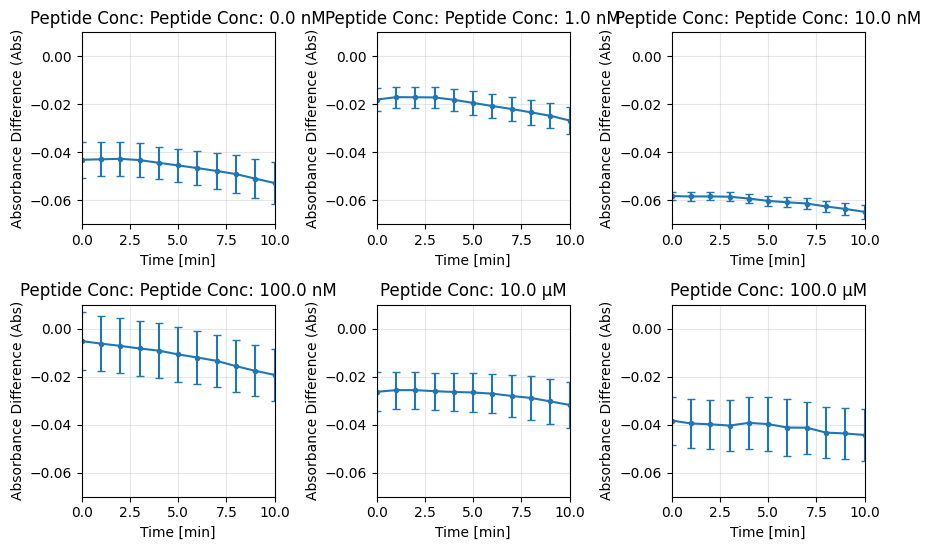

Plotted absorbance difference time series for peptide concentrations: [0.e+00 1.e+00 1.e+01 1.e+02 1.e+04 1.e+05]


In [4]:
# Plot panel of signal time series with error bars
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure signal_ts and signal_sem_ts exist
if 'signal_ts' not in globals() or 'signal_sem_ts' not in globals() or 'pair_concs' not in globals():
     raise RuntimeError("`signal_ts`, `signal_sem_ts`, or `pair_concs` not found in the notebook namespace. Run the cell that creates them first.")

# Detect time column if present in original df
time_col = None
if 'df' in globals():
    for c in df.columns:
        if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
            time_col = c
            break

n = len(pair_concs)
cols = 3
rows = math.ceil(n/cols)
# Set sharex=False to show x-axis on all subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.8), sharex=False) # Increased figure size
axes = axes.flatten()

# Convert time to minutes if available
if time_col is not None and 'df' in globals():
    x = pd.to_numeric(df[time_col], errors='coerce').values / 60.0
    xlabel_text = 'Time [min]'
else:
    x = np.arange(len(next(iter(signal_ts.values())))) # Use the length of the first signal array
    xlabel_text = 'Index'


for i, conc in enumerate(pair_concs):
    ax = axes[i]
    signal = signal_ts.get(conc, np.full(len(x), np.nan))
    sem = signal_sem_ts.get(conc, np.full(len(x), np.nan))

    # Plot in Abs (not milli-Abs): remove scaling by 1000
    signal_plot = np.array(signal, dtype=float)
    sem_plot = (np.array(sem, dtype=float)) if sem is not None else None

    if sem_plot is None:
        ax.plot(x, signal_plot, '-o', ms=3)
    else:
        ax.errorbar(x, signal_plot, yerr=sem_plot, fmt='-o', ms=3, capsize=3)

    # Format the concentration for the title
    if conc < 1000:
        title_conc = f'Peptide Conc: {conc} nM'
    else:
        title_conc = f'{conc/1000} µM'

    ax.set_title(f'Peptide Conc: {title_conc}')
    ax.set_xlabel(xlabel_text) # Explicitly set xlabel for each subplot
    ax.set_ylabel('Absorbance Difference (Abs)') # Updated y-axis label
    ax.grid(alpha=0.3)

    # Set x-axis limit to 10 minutes
    ax.set_xlim(0, 10)

    # Set y-axis limit from -0.07 to 0.01
    ax.set_ylim(-0.07, 0.01)


# hide any extra axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print('Plotted absorbance difference time series for peptide concentrations:', pair_concs)

In [5]:
# Calculate product concentration from normalized absorbance
import pandas as pd

# Ensure df_normalized_signal is present
if 'df_normalized_signal' not in globals():
    raise RuntimeError("`df_normalized_signal` not found in the notebook namespace. Run the cell that creates the normalized absorbance table first.")

# Define constants for Beer-Lambert Law
extinction_coefficient = 6220  # M^-1 cm^-1
path_length = 1  # cm

# Calculate product concentration (c = A / (e * l))
# The normalized absorbance is already in Abs units.
df_product_concentration = df_normalized_signal / (extinction_coefficient * path_length)

# Convert concentration from M to uM for better readability
df_product_concentration_uM = df_product_concentration * 1e6
df_product_concentration_uM.columns = [col.replace(' (Abs)', ' (uM)') for col in df_product_concentration_uM.columns]


print("Product Concentration (uM):")
display(df_product_concentration_uM)

Product Concentration (uM):


,0.0 nM (uM),1.0 nM (uM),10.0 nM (uM),100.0 nM (uM),10000.0 nM (uM),100000.0 nM (uM)
Time [min],,,,,,
0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1.000200,-0.032154,-0.160772,0.026795,0.171490,-0.112540,0.198285
2.000650,-0.064309,-0.155413,0.021436,0.321543,-0.112540,0.251876
3.000950,0.021436,-0.144695,0.042872,0.498392,-0.042872,0.337621
4.001133,0.203644,0.016077,0.166131,0.643087,0.010718,0.155413
5.001300,0.380493,0.225080,0.321543,0.894962,0.042872,0.241158
6.001533,0.557342,0.434084,0.418006,1.103966,0.123258,0.471597
7.001700,0.750268,0.632369,0.498392,1.329046,0.278671,0.482315
8.001900,0.959271,0.857449,0.696677,1.682744,0.412647,0.809218


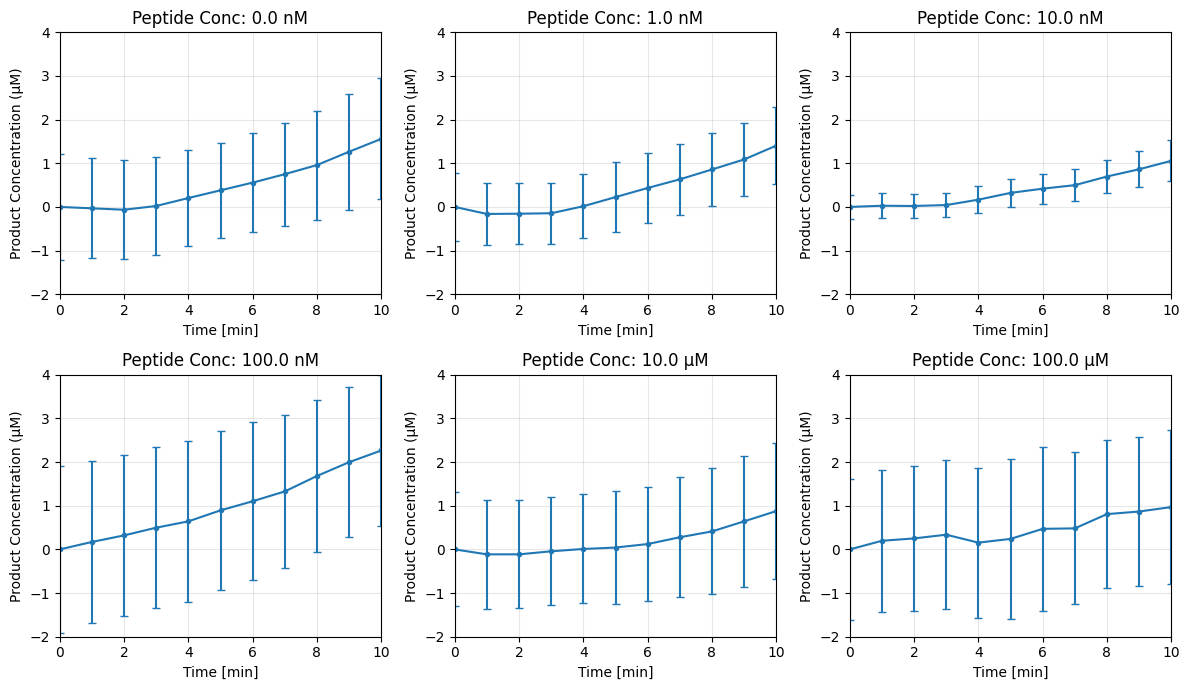

In [6]:
# Plot product concentration time series with error bars
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Ensure df_product_concentration_uM and signal_sem_ts are present
if 'df_product_concentration_uM' not in globals() or 'signal_sem_ts' not in globals() or 'pair_concs' not in globals():
    raise RuntimeError("`df_product_concentration_uM`, `signal_sem_ts`, or `pair_concs` not found in the notebook namespace. Run the cells that create them first.")

# Define constants for Beer-Lambert Law (needed to scale SEM)
extinction_coefficient = 6220  # M^-1 cm^-1
path_length = 1  # cm

df_plot = df_product_concentration_uM.copy()

n_concs = len(df_plot.columns)
cols = 3
rows = math.ceil(n_concs / cols) # Calculate rows needed

# Set sharex=False to show x-axis on all subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3.5), sharex=False) # Increased figure size
axes = axes.flatten()

for i, col in enumerate(df_plot.columns):
    ax = axes[i]
    conc_str = col.split(' ')[0] # Extract concentration string from column name
    conc = float(conc_str)

    # Get the corresponding SEM from signal_sem_ts and convert to uM product concentration SEM
    sem_abs = signal_sem_ts.get(conc, np.full(len(df_plot), np.nan))
    sem_uM = (np.array(sem_abs, dtype=float) / (extinction_coefficient * path_length)) * 1e6 if sem_abs is not None else None

    if sem_uM is None:
         ax.plot(df_plot.index, df_plot[col], '-o', ms=3)
    else:
         ax.errorbar(df_plot.index, df_plot[col], yerr=sem_uM, fmt='-o', ms=3, capsize=3)


    # Format the concentration for the title
    if conc < 1000:
        title_conc = f'Peptide Conc: {conc} nM'
    else:
        title_conc = f'Peptide Conc: {conc/1000} µM'

    ax.set_title(title_conc)
    ax.set_xlabel('Time [min]') # Explicitly set xlabel for each subplot
    ax.set_ylabel('Product Concentration (µM)')
    ax.grid(alpha=0.3)
    # Set x-axis limit to 10 minutes
    ax.set_xlim(0, 10)
    # Set y-axis limit from -2 to 4
    ax.set_ylim(-2, 4)


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Calculate initial reaction velocities from product concentration data (0-10 min)
import pandas as pd
import numpy as np
from scipy.stats import linregress

# Ensure df_product_concentration_uM is present
if 'df_product_concentration_uM' not in globals():
    raise RuntimeError("`df_product_concentration_uM` not found in the notebook namespace. Run the cell that creates the product concentration table first.")

df_product_conc = df_product_concentration_uM.copy()

# Detect time column if present in original df to get x-axis values
time_col = None
if 'df' in globals():
    for c in df.columns:
        if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
            time_col = c
            break

if time_col is not None and 'df' in globals():
    x = pd.to_numeric(df[time_col], errors='coerce').values / 60.0  # Time in minutes
else:
    x = df_product_conc.index.values # Use the index of the product concentration dataframe

# Filter data to the first 10 minutes (keeping previous analysis)
time_limit_0_10 = 10.0
if time_col is not None:
    # Find the index where time exceeds 10 minutes
    time_in_seconds = pd.to_numeric(df[time_col], errors='coerce').values
    index_limit_0_10 = np.where(time_in_seconds > time_limit_0_10 * 60)[0]
    if len(index_limit_0_10) > 0:
        index_limit_0_10 = index_limit_0_10[0]
    else:
        index_limit_0_10 = len(x) # if all data is within 10 min, use all data
else:
    # If no time column, assume each index is a time point and take first 10
    index_limit_0_10 = min(int(time_limit_0_10), len(x)) # Assuming index corresponds to minutes approximately, or just take first 10 points

x_subset_0_10 = x[:index_limit_0_10]
df_subset_0_10 = df_product_conc.iloc[:index_limit_0_10]

velocities_data_0_10 = {}
for col in df_subset_0_10.columns:
    # Perform linear regression on the subsetted data
    slope, intercept, r_value, p_value, std_err = linregress(x_subset_0_10, df_subset_0_10[col])
    velocities_data_0_10[col.replace(' (uM)', '')] = {'Velocity (uM/min)': slope, 'Std Error (uM/min)': std_err}

# Create a DataFrame for velocities (0-10 min)
df_velocities_0_10 = pd.DataFrame.from_dict(velocities_data_0_10, orient='index')

print("Calculated Initial Velocities and Standard Errors (0-{} min):".format(time_limit_0_10))
display(df_velocities_0_10)

# Calculate initial reaction velocities from product concentration data (5-8 min)
time_start_5_8 = 5.0
time_end_5_8 = 8.0

if time_col is not None:
    # Find the indices for the 5-8 minute range
    time_in_seconds = pd.to_numeric(df[time_col], errors='coerce').values
    index_start_5_8 = np.where(time_in_seconds >= time_start_5_8 * 60)[0]
    if len(index_start_5_8) > 0:
        index_start_5_8 = index_start_5_8[0]
    else:
        index_start_5_8 = 0 # If no data after 5 min, use all data

    index_end_5_8 = np.where(time_in_seconds > time_end_5_8 * 60)[0]
    if len(index_end_5_8) > 0:
        index_end_5_8 = index_end_5_8[0]
    else:
        index_end_5_8 = len(x) # if all data is within 8 min, use all data

else:
    # If no time column, assume each index is a time point and take indices 5 to 8
    index_start_5_8 = min(int(time_start_5_8), len(x))
    index_end_5_8 = min(int(time_end_5_8), len(x))


# Ensure the subset is not empty
if index_end_5_8 <= index_start_5_8:
     raise ValueError("Time range 5-8 minutes is empty or invalid. Check your data or time column.")

x_subset_5_8 = x[index_start_5_8:index_end_5_8]
df_subset_5_8 = df_product_conc.iloc[index_start_5_8:index_end_5_8]

velocities_data_5_8 = {}
for col in df_subset_5_8.columns:
    # Perform linear regression on the subsetted data
    slope, intercept, r_value, p_value, std_err = linregress(x_subset_5_8, df_subset_5_8[col])
    velocities_data_5_8[col.replace(' (uM)', '')] = {'Velocity (uM/min)': slope, 'Std Error (uM/min)': std_err}

# Create a DataFrame for velocities (5-8 min)
df_velocities_5_8 = pd.DataFrame.from_dict(velocities_data_5_8, orient='index')

print("\nCalculated Initial Velocities and Standard Errors (5-8 min):")
display(df_velocities_5_8)


# Calculate initial reaction velocities from product concentration data (3-8 min)
time_start_3_8 = 3.0
time_end_3_8 = 8.0

if time_col is not None:
    # Find the indices for the 3-8 minute range
    time_in_seconds = pd.to_numeric(df[time_col], errors='coerce').values
    index_start_3_8 = np.where(time_in_seconds >= time_start_3_8 * 60)[0]
    if len(index_start_3_8) > 0:
        index_start_3_8 = index_start_3_8[0]
    else:
        index_start_3_8 = 0 # If no data after 3 min, use all data

    index_end_3_8 = np.where(time_in_seconds > time_end_3_8 * 60)[0]
    if len(index_end_3_8) > 0:
        index_end_3_8 = index_end_3_8[0]
    else:
        index_end_3_8 = len(x) # if all data is within 8 min, use all data

else:
    # If no time column, assume each index is a time point and take indices 3 to 8
    index_start_3_8 = min(int(time_start_3_8), len(x))
    index_end_3_8 = min(int(time_end_3_8), len(x))


# Ensure the subset is not empty
if index_end_3_8 <= index_start_3_8:
     raise ValueError("Time range 3-8 minutes is empty or invalid. Check your data or time column.")

x_subset_3_8 = x[index_start_3_8:index_end_3_8]
df_subset_3_8 = df_product_conc.iloc[index_start_3_8:index_end_3_8]

velocities_data_3_8 = {}
for col in df_subset_3_8.columns:
    # Perform linear regression on the subsetted data
    slope, intercept, r_value, p_value, std_err = linregress(x_subset_3_8, df_subset_3_8[col])
    velocities_data_3_8[col.replace(' (uM)', '')] = {'Velocity (uM/min)': slope, 'Std Error (uM/min)': std_err}

# Create a DataFrame for velocities (3-8 min)
df_velocities_3_8 = pd.DataFrame.from_dict(velocities_data_3_8, orient='index')

print("\nCalculated Initial Velocities and Standard Errors (3-8 min):")
display(df_velocities_3_8)

# Calculate initial reaction velocities from product concentration data (2-8 min)
time_start_2_8 = 2.0
time_end_2_8 = 8.0

if time_col is not None:
    # Find the indices for the 2-8 minute range
    time_in_seconds = pd.to_numeric(df[time_col], errors='coerce').values
    index_start_2_8 = np.where(time_in_seconds >= time_start_2_8 * 60)[0]
    if len(index_start_2_8) > 0:
        index_start_2_8 = index_start_2_8[0]
    else:
        index_start_2_8 = 0 # If no data after 2 min, use all data

    index_end_2_8 = np.where(time_in_seconds > time_end_2_8 * 60)[0]
    if len(index_end_2_8) > 0:
        index_end_2_8 = index_end_2_8[0]
    else:
        index_end_2_8 = len(x) # if all data is within 8 min, use all data

else:
    # If no time column, assume each index is a time point and take indices 2 to 8
    index_start_2_8 = min(int(time_start_2_8), len(x))
    index_end_2_8 = min(int(time_end_2_8), len(x))


# Ensure the subset is not empty
if index_end_2_8 <= index_start_2_8:
     raise ValueError("Time range 2-8 minutes is empty or invalid. Check your data or time column.")

x_subset_2_8 = x[index_start_2_8:index_end_2_8]
df_subset_2_8 = df_product_conc.iloc[index_start_2_8:index_end_2_8]

velocities_data_2_8 = {}
for col in df_subset_2_8.columns:
    # Perform linear regression on the subsetted data
    slope, intercept, r_value, p_value, std_err = linregress(x_subset_2_8, df_subset_2_8[col])
    velocities_data_2_8[col.replace(' (uM)', '')] = {'Velocity (uM/min)': slope, 'Std Error (uM/min)': std_err}

# Create a DataFrame for velocities (2-8 min)
df_velocities_2_8 = pd.DataFrame.from_dict(velocities_data_2_8, orient='index')

print("\nCalculated Initial Velocities and Standard Errors (2-8 min):")
display(df_velocities_2_8)


# Calculate initial reaction velocities from product concentration data (4-8 min)
time_start_4_8 = 4.0
time_end_4_8 = 8.0

if time_col is not None:
    # Find the indices for the 4-8 minute range
    time_in_seconds = pd.to_numeric(df[time_col], errors='coerce').values
    index_start_4_8 = np.where(time_in_seconds >= time_start_4_8 * 60)[0]
    if len(index_start_4_8) > 0:
        index_start_4_8 = index_start_4_8[0]
    else:
        index_start_4_8 = 0 # If no data after 4 min, use all data

    index_end_4_8 = np.where(time_in_seconds > time_end_4_8 * 60)[0]
    if len(index_end_4_8) > 0:
        index_end_4_8 = index_end_4_8[0]
    else:
        index_end_4_8 = len(x) # if all data is within 8 min, use all data

else:
    # If no time column, assume each index is a time point and take indices 4 to 8
    index_start_4_8 = min(int(time_start_4_8), len(x))
    index_end_4_8 = min(int(time_end_4_8), len(x))


# Ensure the subset is not empty
if index_end_4_8 <= index_start_4_8:
     raise ValueError("Time range 4-8 minutes is empty or invalid. Check your data or time column.")

x_subset_4_8 = x[index_start_4_8:index_end_4_8]
df_subset_4_8 = df_product_conc.iloc[index_start_4_8:index_end_4_8]

velocities_data_4_8 = {}
for col in df_subset_4_8.columns:
    # Perform linear regression on the subsetted data
    slope, intercept, r_value, p_value, std_err = linregress(x_subset_4_8, df_subset_4_8[col])
    velocities_data_4_8[col.replace(' (uM)', '')] = {'Velocity (uM/min)': slope, 'Std Error (uM/min)': std_err}

# Create a DataFrame for velocities (4-8 min)
df_velocities_4_8 = pd.DataFrame.from_dict(velocities_data_4_8, orient='index')

print("\nCalculated Initial Velocities and Standard Errors (4-8 min):")
display(df_velocities_4_8)


# Keep the original df_velocities pointing to the 0-10 min data for compatibility with downstream cells
df_velocities = df_velocities_0_10.copy()

Calculated Initial Velocities and Standard Errors (0-10.0 min):


,Velocity (uM/min),Std Error (uM/min)
0.0 nM,0.146511,0.016543
1.0 nM,0.138165,0.020360
10.0 nM,0.097674,0.010028
100.0 nM,0.216163,0.010959
10000.0 nM,0.072411,0.013394
100000.0 nM,0.083192,0.014324



Calculated Initial Velocities and Standard Errors (5-8 min):


,Velocity (uM/min),Std Error (uM/min)
0.0 nM,0.184850,0.004644
1.0 nM,0.203603,0.003090
10.0 nM,0.088407,0.004638
100.0 nM,0.216998,0.004644
10000.0 nM,0.117875,0.021656
100000.0 nM,0.120556,0.063413



Calculated Initial Velocities and Standard Errors (3-8 min):


,Velocity (uM/min),Std Error (uM/min)
0.0 nM,0.181102,0.001637
1.0 nM,0.197176,0.005064
10.0 nM,0.116269,0.008132
100.0 nM,0.212178,0.009029
10000.0 nM,0.075548,0.013523
100000.0 nM,0.060546,0.038601



Calculated Initial Velocities and Standard Errors (2-8 min):


,Velocity (uM/min),Std Error (uM/min)
0.0 nM,0.167321,0.008028
1.0 nM,0.168086,0.017118
10.0 nM,0.104710,0.008537
100.0 nM,0.202990,0.007942
10000.0 nM,0.071031,0.009229
100000.0 nM,0.046844,0.026479



Calculated Initial Velocities and Standard Errors (4-8 min):


,Velocity (uM/min),Std Error (uM/min)
0.0 nM,0.181637,0.002785
1.0 nM,0.205748,0.001855
10.0 nM,0.109304,0.012242
100.0 nM,0.226644,0.005944
10000.0 nM,0.088407,0.019577
100000.0 nM,0.121092,0.028361


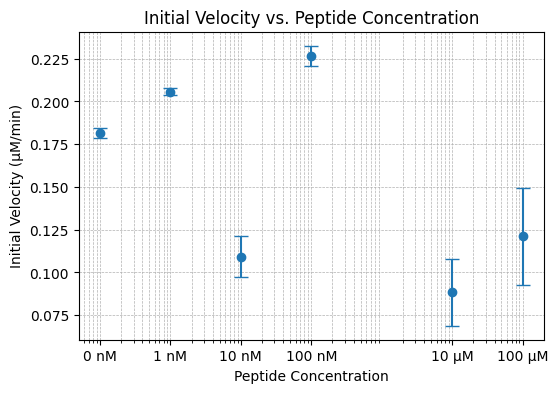

In [8]:
# Plot initial velocity versus peptide concentration (log scale) with error bars
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure df_velocities is present
if 'df_velocities_4_8' not in globals(): # Changed to check for df_velocities_4_8
    raise RuntimeError("`df_velocities_4_8` not found in the notebook namespace. Run the cell that calculates initial velocities for the 4-8 min range first.") # Updated error message

# Use the velocities calculated from the 4-8 minute range
df_plot = df_velocities_4_8.copy()

# Extract peptide concentrations and velocities
# The index of df_velocities contains the concentrations as strings with " nM" or " uM"
concentrations = []
velocities = []
std_errors = []

for index, row in df_plot.iterrows():
    conc_str = index.replace(' nM', '').replace(' uM', '')
    conc = float(conc_str)
    # Convert µM concentrations from the index back to nM for log plotting
    if 'uM' in index:
        conc *= 1000 # Convert uM to nM
    concentrations.append(conc)
    velocities.append(row['Velocity (uM/min)'])
    std_errors.append(row['Std Error (uM/min)'])

concentrations = np.array(concentrations)
velocities = np.array(velocities)
std_errors = np.array(std_errors)

# Handle 0 nM concentration by mapping to a small positive value for log scale plotting
# Inspired by the provided code snippet, use a value relative to the minimum non-zero concentration
concentrations_plot = np.array(concentrations)
non_zero_concs = concentrations_plot[concentrations_plot > 0]
small_positive_value = (non_zero_concs.min() / 10.0) if non_zero_concs.size > 0 else 1e-6
concentrations_plot[concentrations_plot == 0] = small_positive_value

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4)) # Increased figure size and got ax object
ax.errorbar(concentrations_plot, velocities, yerr=std_errors, fmt='o', capsize=5)

# Set x-axis to log scale
ax.set_xscale('log')


# Define custom x-axis ticks and labels
custom_ticks_nM = [0, 1, 10, 100, 10000, 100000]
# Replace 0 in ticks with the small positive value for plotting purposes
custom_ticks_plot = [small_positive_value if x == 0 else x for x in custom_ticks_nM]
custom_labels = ['0 nM', '1 nM', '10 nM', '100 nM', '10 µM', '100 µM'] # Corrected label for 10000 nM

ax.set_xticks(custom_ticks_plot)
ax.set_xticklabels(custom_labels)


ax.set_xlabel('Peptide Concentration') # Updated xlabel
ax.set_ylabel('Initial Velocity (µM/min)')
ax.set_title('Initial Velocity vs. Peptide Concentration') # Updated title
ax.grid(True, which="both", linestyle='--', linewidth=0.5)


plt.show()